In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
import json

with open("/content/drive/MyDrive/Research/new_model_classes.json") as openfile:
  classes = json.load(openfile)
classes

{'leaf': ['Tomato', 'Potato', 'Pepperbell'],
 'disease': ['Tomato_Lateblight',
  'Potato_Lateblight',
  'Pepperbell_healthy',
  'Tomato_Bacterialspot',
  'Tomato_SpiderMitesTwoSpottedSpiderMite',
  'Tomato_TargetSpot',
  'Tomato_healthy',
  'Potato_Earlyblight',
  'Tomato_TomatoYellowLeafCurlVirus',
  'Tomato_Septorialeafspot',
  'Tomato_TomatoMosaicVirus',
  'Tomato_Earlyblight',
  'Pepperbell_Bacterial_spot',
  'Potato_healthy',
  'Tomato_LeafMold']}

In [ ]:
FILE="/content/drive/MyDrive/Research/PlantVillage"

In [ ]:
folder_names=os.listdir(FILE)
paths=[]
for x in folder_names:
  for y in os.listdir(FILE+"/"+x):
    paths.append(FILE+"/"+x+"/"+y)
random.shuffle(paths)


In [ ]:
paths[0].split('/')[6].split("_")[0]

'Potato'

In [ ]:
classes['leaf'].index("Tomato")

0

In [ ]:
def categorical(index, size):
  l=[0 for x in range(size)]
  l[index] = 1
  return tf.convert_to_tensor(np.array(l))

In [ ]:
import pandas as pd

disease=[categorical(classes['disease'].index(path.split('/')[6]),15) for path in paths]
leaf=[categorical(classes['leaf'].index(path.split('/')[6].split("_")[0]),3) for path in paths]
dataset= pd.DataFrame({'paths':[str(path) for path in paths], 'leaf':leaf, "disease":disease})
# dataset['leaf'] = dataset['leaf'].astype('category')
# dataset['disease'] = dataset['disease'].astype('category')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641 entries, 0 to 20640
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   paths    20641 non-null  object
 1   leaf     20641 non-null  object
 2   disease  20641 non-null  object
dtypes: object(3)
memory usage: 483.9+ KB


In [ ]:
dataset.head

<bound method NDFrame.head of                                                    paths  \
0      /content/drive/MyDrive/Research/PlantVillage/P...   
1      /content/drive/MyDrive/Research/PlantVillage/T...   
2      /content/drive/MyDrive/Research/PlantVillage/P...   
3      /content/drive/MyDrive/Research/PlantVillage/T...   
4      /content/drive/MyDrive/Research/PlantVillage/P...   
...                                                  ...   
20636  /content/drive/MyDrive/Research/PlantVillage/T...   
20637  /content/drive/MyDrive/Research/PlantVillage/T...   
20638  /content/drive/MyDrive/Research/PlantVillage/T...   
20639  /content/drive/MyDrive/Research/PlantVillage/T...   
20640  /content/drive/MyDrive/Research/PlantVillage/T...   

                                                    leaf  \
0      (tf.Tensor(0, shape=(), dtype=int64), tf.Tenso...   
1      (tf.Tensor(1, shape=(), dtype=int64), tf.Tenso...   
2      (tf.Tensor(0, shape=(), dtype=int64), tf.Tenso...   
3      (t

#Image Gen

In [ ]:
image_gen= tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [ ]:
train_data = image_gen.flow_from_dataframe(dataset,batch_size=32,target_size=(224,224), x_col='paths', y_col=['leaf','disease'],classes = classes, class_mode="multi_output",subset="training")
val_data = image_gen.flow_from_dataframe(dataset,batch_size=32,target_size=(224,224), x_col='paths', y_col=['leaf','disease'],classes = classes, class_mode="multi_output",subset="validation")

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1071: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  warnings.warn(


Found 16511 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn(


Found 4127 validated image filenames.


In [ ]:
print(train_data[0])

(array([[[[169., 168., 182.],
         [168., 167., 181.],
         [168., 167., 181.],
         ...,
         [192., 192., 204.],
         [190., 190., 202.],
         [189., 189., 201.]],

        [[167., 166., 180.],
         [166., 165., 179.],
         [165., 164., 178.],
         ...,
         [192., 192., 204.],
         [190., 190., 202.],
         [189., 189., 201.]],

        [[170., 169., 183.],
         [169., 168., 182.],
         [168., 167., 181.],
         ...,
         [192., 192., 204.],
         [191., 191., 203.],
         [190., 190., 202.]],

        ...,

        [[131., 128., 139.],
         [131., 128., 139.],
         [131., 128., 139.],
         ...,
         [149., 145., 159.],
         [149., 145., 159.],
         [159., 155., 169.]],

        [[127., 124., 135.],
         [127., 124., 135.],
         [128., 125., 136.],
         ...,
         [155., 151., 165.],
         [147., 143., 157.],
         [150., 146., 160.]],

        [[125., 122., 133.],
      

#Model

In [ ]:
num_leaf_classes=len(classes['leaf'])
num_disease_classes=len(classes['disease'])
num_disease_classes

15

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

# Define the input shape (adjust as needed)
input_shape = (224, 224, 3)

# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False
input_layer = Input(shape=input_shape, batch_size=32)
feature_map = inception_model(input_layer)
feature_map_flatten = Flatten()(feature_map)

leaf_output = Dense(num_leaf_classes, activation='softmax', name='leaf_output')(feature_map_flatten)

disease_input = concatenate([feature_map_flatten, leaf_output],name='disease_input')
disease_output = Dense(num_disease_classes, activation='softmax', name='disease_output')(disease_input)

disease_classifier = Model(inputs=input_layer, outputs=[leaf_output, disease_output])

disease_classifier.compile(optimizer=Adam(lr=0.001), loss=['CategoricalCrossentropy', 'CategoricalCrossentropy'], metrics={'leaf_output': 'accuracy', 'disease_output': 'accuracy'})



In [ ]:
disease_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(32, 224, 224, 3)]          0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 flatten_1 (Flatten)         (32, 51200)                  0         ['inception_v3[0][0]']        
                                                                                                  
 leaf_output (Dense)         (32, 3)                      153603    ['flatten_1[0][0]']       

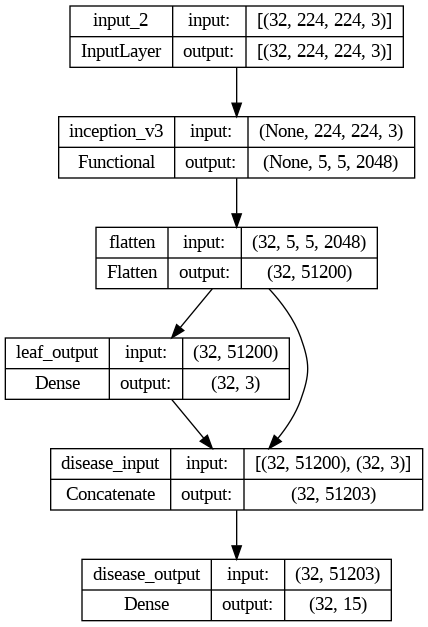

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(disease_classifier, to_file='disease_classifier.png', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement before stopping
    verbose=1,            # Display messages about early stopping
    restore_best_weights=True  # Restore the model weights to the best achieved during training
)

In [ ]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=val_data.n//val_data.batch_size

In [ ]:
history = disease_classifier.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stopping])

Epoch 1/50
516/516 [==============================] - 2371s 5s/step - loss: 100.0421 - leaf_output_loss: 18.0598 - disease_output_loss: 81.9822 - leaf_output_accuracy: 0.8265 - disease_output_accuracy: 0.4740 - val_loss: 72.9641 - val_leaf_output_loss: 12.6848 - val_disease_output_loss: 60.2793 - val_leaf_output_accuracy: 0.8711 - val_disease_output_accuracy: 0.5609
Epoch 2/50
516/516 [==============================] - 2374s 5s/step - loss: 70.9312 - leaf_output_loss: 14.1285 - disease_output_loss: 56.8027 - leaf_output_accuracy: 0.8762 - disease_output_accuracy: 0.6113 - val_loss: 82.4754 - val_leaf_output_loss: 11.3178 - val_disease_output_loss: 71.1576 - val_leaf_output_accuracy: 0.8905 - val_disease_output_accuracy: 0.5658
Epoch 3/50
516/516 [==============================] - 2372s 5s/step - loss: 62.8026 - leaf_output_loss: 14.3452 - disease_output_loss: 48.4574 - leaf_output_accuracy: 0.8924 - disease_output_accuracy: 0.6662 - val_loss: 84.7013 - val_leaf_output_loss: 14.3762 - v

In [ ]:
print(history.history)

{'loss': [100.0420913696289, 70.93122100830078, 62.802589416503906, 57.369590759277344, 53.226009368896484, 46.56565856933594], 'leaf_output_loss': [18.059844970703125, 14.128493309020996, 14.345163345336914, 12.839034080505371, 9.3114652633667, 10.261178970336914], 'disease_output_loss': [81.982177734375, 56.802734375, 48.45741271972656, 44.53057098388672, 43.91453552246094, 36.30447769165039], 'leaf_output_accuracy': [0.8264793157577515, 0.876203715801239, 0.8923747539520264, 0.903700590133667, 0.9221730828285217, 0.9232026934623718], 'disease_output_accuracy': [0.47404760122299194, 0.6113499999046326, 0.6661619544029236, 0.702743649482727, 0.7251529097557068, 0.7605838775634766], 'val_loss': [72.96411895751953, 82.47538757324219, 84.70132446289062, 124.8646469116211, 95.4283676147461, 99.36974334716797], 'val_leaf_output_loss': [12.684825897216797, 11.317757606506348, 14.376208305358887, 42.413089752197266, 12.741682052612305, 15.33725357055664], 'val_disease_output_loss': [60.27931

In [ ]:
acc = history.history['leaf_output_accuracy']
val_acc = history.history['val_leaf_output_accuracy']

loss = history.history['leaf_output_loss']
val_loss = history.history['val_leaf_output_loss']
EPOCHS=6

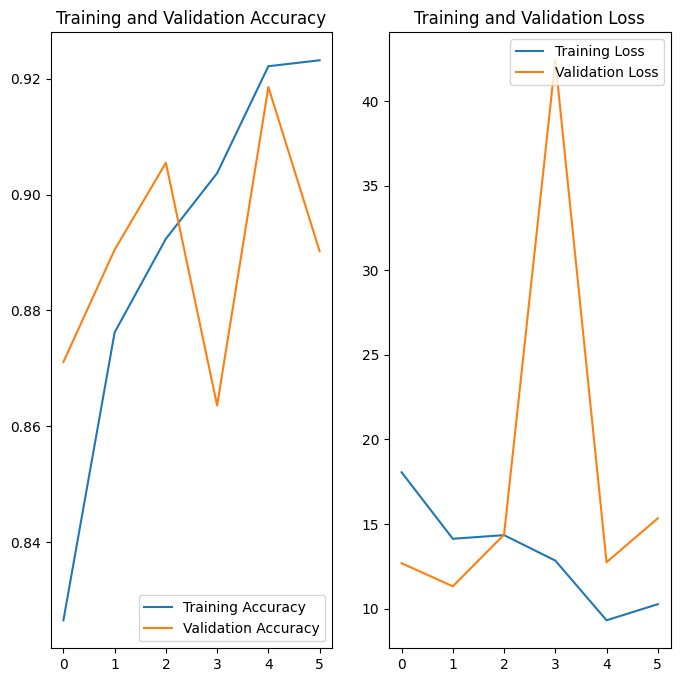

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

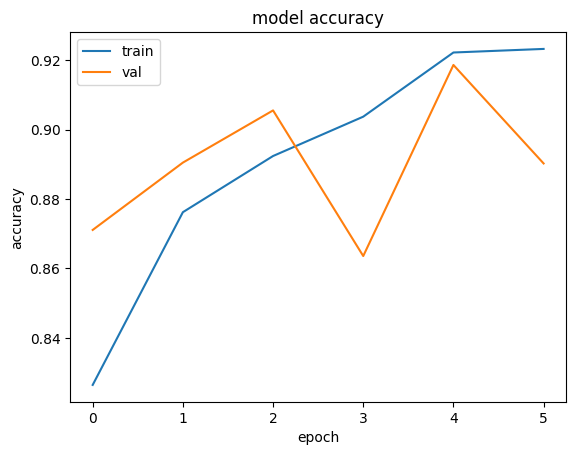

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['leaf_output_accuracy'])
plt.plot(history.history['val_leaf_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

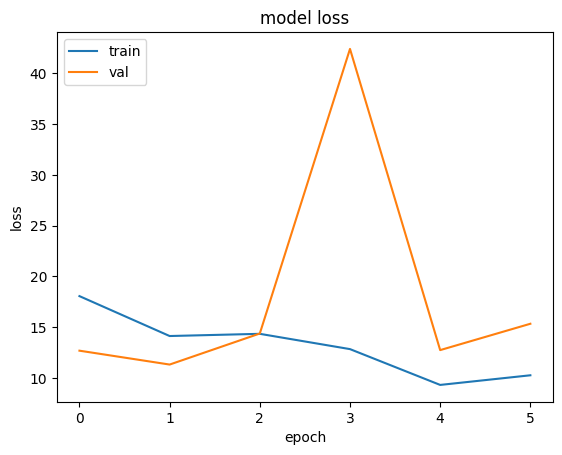

In [ ]:
plt.plot(history.history['leaf_output_loss'])
plt.plot(history.history['val_leaf_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
disease_classifier.save("/content/drive/MyDrive/Research/new-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
len(train_data[0][1][1][1])

15

In [ ]:
classes['disease']

['Tomato_Lateblight',
 'Potato_Lateblight',
 'Pepperbell_healthy',
 'Tomato_Bacterialspot',
 'Tomato_SpiderMitesTwoSpottedSpiderMite',
 'Tomato_TargetSpot',
 'Tomato_healthy',
 'Potato_Earlyblight',
 'Tomato_TomatoYellowLeafCurlVirus',
 'Tomato_Septorialeafspot',
 'Tomato_TomatoMosaicVirus',
 'Tomato_Earlyblight',
 'Pepperbell_Bacterial_spot',
 'Potato_healthy',
 'Tomato_LeafMold']

In [ ]:
np.argmax(train_data[0][1][1][2])

11

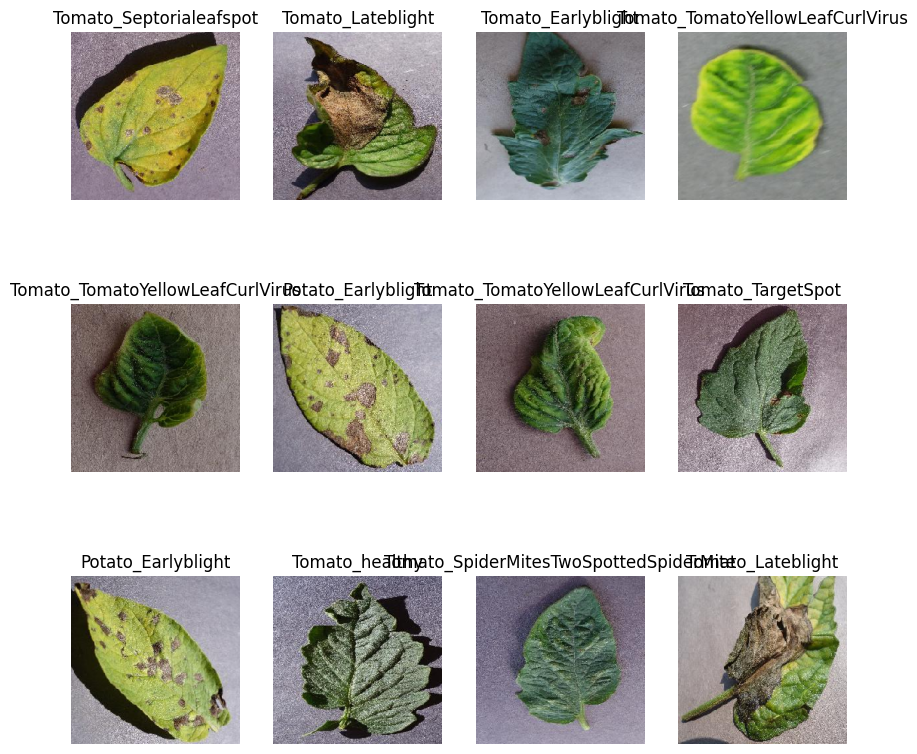

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(train_data[0][0][i].astype("uint8"))
    # print(train_data[0][1][1][i])
    plt.title(classes['disease'][np.argmax(train_data[0][1][1][i])])
    plt.axis("off")

In [ ]:
import tensorflow as tf


In [ ]:
model= tf.keras.models.load_model("/content/drive/MyDrive/Research/new-model.h5")

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load your disease prediction model
model = load_model('/content/drive/MyDrive/Research/new-model.h5')  # Update with your actual model file

# Define a function to preprocess the image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define a function to make predictions
def predict_disease(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    return prediction

# Streamlit App
st.title("Disease Prediction App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    st.image(uploaded_file, caption="Uploaded Image.", use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Make prediction
    prediction = predict_disease(uploaded_file)

    # Display the prediction results
    st.write(f"Prediction: {prediction}")


2023-11-29 16:51:02.867 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
